In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps("2012-01-01", "2012-12-31"))

[(56.0, 72.26401515151515, 86.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
start_date = "2012-01-01"
end_date = "2012-12-31"

# Convert string date to datetime format 
start_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()

# Calc_temps functions to calculate the tmin, tavg, and tmax 
temps = calc_temps(start_dt, end_dt)
tmin = temps[0][0]
tavg = round(temps[0][1], 2)
tmax = temps[0][2]

print(f"Temperatures from {start_dt} to {end_dt}:")
print(f"Minimum temp: {tmin} | Average temp: {tavg} | Max temp: {tmax}")

Temperatures from 2012-01-01 to 2012-12-31:
Minimum temp: 56.0 | Average temp: 72.26 | Max temp: 86.0


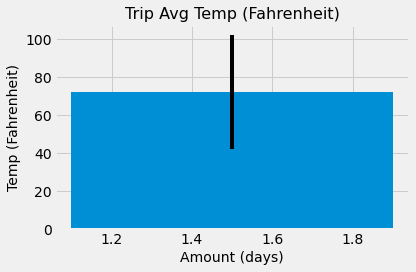

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(1.5, height=tavg, yerr=tmax-tmin)

plt.title("Trip Avg Temp (Fahrenheit)", fontsize = 16)
plt.ylabel("Temp (Fahrenheit)", fontsize=14)
plt.xlabel("Amount (days)", fontsize=14)

plt.tight_layout()
plt.savefig("Trip_Avg_Temp.png")
plt.show()

### Daily Rainfall Average

In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Precipitation dataframe from Measurement 
Precipitation_station_df = pd.DataFrame(session.query(Measurement.date, Measurement.station, Measurement.prcp).\
                               filter((Measurement.date>=start_dt) & (Measurement.date<=end_dt)).all())
Precipitation_station_renamed_df = Precipitation_station_df.rename(columns={0:"Date", 1:"Station", 2:"Precipitation"}) 
Precipitation_station_renamed_df
# Precipitation_station_renamed_df.dropna(axis=0, how="any", inplace=True)

# Group by station 
Precipitation_station_grouped_df = pd.DataFrame(Precipitation_station_renamed_df.groupby("Station").sum())
Precipitation_station_grouped_df

# Station dataframe from Measurement Table
Station_df = pd.DataFrame(session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all())
Station_renamed_df = Station_df.rename(columns={0:"Station",1:"Station Name",2:"Latitude",3:"Longitude",4:"Elevation"}) 
Station_renamed_df

# Merge dataframes & sort by Station Precipitation
Precipitation_per_station_df = pd.merge(Precipitation_station_grouped_df, Station_renamed_df, on="Station")
Precipitation_per_station_df.sort_values("Precipitation", ascending=False, inplace=True)
# Precipitation_per_station_df.reset_index(inplace=True, drop=True)
Precipitation_per_station_df

,Station,Precipitation,Station Name,Latitude,Longitude,Elevation
3,USC00516128,122.59,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
6,USC00519281,54.90,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00513117,32.50,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
8,USC00519523,27.76,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2,USC00514830,14.47,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,USC00519397,14.22,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00518838,9.59,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
0,USC00511918,9.17,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
4,USC00517948,2.26,"PEARL CITY, HI US",21.39340,-157.97510,11.9


### Daily Temperature Normals

In [53]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [59]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start2_date = "2017-08-01"
end2_date = "2017-08-07"

# Use the start and end date to create a range of dates
start2_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end2_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()
trip_duration = end2_dt - start2_dt

# Strip off the year and save a list of strings in the format %m-%d

normal_dates = []
for i in range(trip_duration.days + 1):
    current_day = start2_dt + dt.timedelta(days=i)
    month_day = dt.datetime.strftime(current_day,'%m-%d')
    #normals.append(month_day)
    normal_dates.append(month_day)


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for day in normal_dates:
    normals.append(daily_normals(day)[0])
normals_list

[]

In [61]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=["tmin", "tavg", "tmax"], index=[normal_dates])
normals_df.index = normals_df.index.get_level_values(0)
normals_df.head()

ValueError: Shape of passed values is (1098, 3), indices imply (366, 3)

C:\Users\viksh\AppData\Local\Temp/ipykernel_16328/3944321762.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


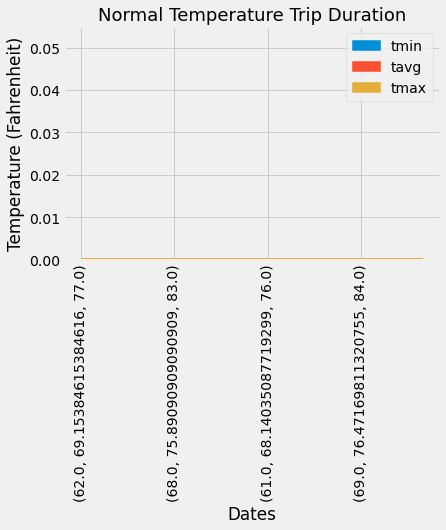

In [64]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area", rot=90)

plt.title("Normal Temperature Trip Duration", fontsize=18)
plt.ylabel("Temperature (Fahrenheit)")
plt.xlabel("Dates")

plt.tight_layout()
plt.savefig("Normal_Temperature_Trip_Duration.png")
plt.show()

## Close Session

In [ ]:
session.close()